# 5 Training ML models with Serotiny
This notebook shows how to
-  5.1 load libraries, predefined functions and the main dataset 
-  5.2 parametrize a ML task using serotiny's yamls 
-  5.3 train a classification model based on 2D images
-  5.4 load a pretrained model
-  5.4 train a classification model based on 3D images

## 5.1 Load libraries, predefine some functions, and load the manifest 


### Load libraries and predefined functions

In [38]:
# First "pip install -e ." from command line (when in cytodata-hackathon-base)

import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("bfio.backends").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)

from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

### Load the manifest and explore dimensions

In [39]:
cells_df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")
print(f'Number of cells: {len(cells_df)}')
print(f'Number of columns: {len(cells_df.columns)}')

Number of cells: 215081
Number of columns: 1242


## 5.2 Parametrize a ML task using serotiny's yamls

`serotiny` is a Python package and framework to help you create configurable and reproducible DL projects. It uses [hydra](https://hydra.cc/) for configurability, [MLFlow](https://mlflow.org/) for experiment tracking,
and [Pytorch Lightning](https://pytorchlightning.ai/) for DL model training/testing/predictions.

### Project structure
With `serotiny` a DL project has a predefined structure (which this repo already complies with). To start a new project with the appropriate structure, you can use the [serotiny-project cookiecutter](https://github.com/allencellmodeling/serotiny-project-cookiecutter)

A serotiny project contains a Python package, and a config folder. This config folder is composed of 5 config groups:
- `data` : where we configure access to datasets
- `model` : where we define and parameterize models/networks
- `trainer` : where we setup the Pytorch Lightning trainer
- `trainer/callbacks` : where we (optionally) add a list of callbacks to be run in train/test/prediction
- `mlflow`: where we configure access to a MLFlow server, where our experiments and results will be tracked and stored

<img src="resources/serotiny.png" width="800"/>

### `serotiny` commands
Aside from the predefined structure and config folder, `serotiny` has set of commands which know how to read a project's configuration (and override it)
and execute DL tasks.

For example, we could train a model using the a model config called `my_classifier` (which would live in `config/model/my_classifier.yaml`), and a data config
called `my_train_data` (which would live in `config/data/my_train_data.yaml`) and overriding some of the `mlflow` config parameters.
<br><small>Note: Because we didn't specify a top-level `mlflow` config, i.e. we didn't do `mlflow=...`, `serotiny` will use the default config, which lives in `config/mlflow/default.yaml`</small>

```
$ serotiny train model=my_classifier data=my_train_data mlflow.experiment_name=some_experiment mlflow.run_name=1st_run
```

Once the model finishes training, we could use it to make predictions on a different dataset, configured in `my_predict_data`

```
$ serotiny predict model=my_classifier data=my_predict_data mlflow.experiment_name=some_experiment mlflow.run_name=1st_run
```


## 5.3 Train a classification model based on 2D images


### Make a simple dataset of edge vs. non-edge cells

In [40]:
from serotiny.transforms.dataframe.transforms import split_dataframe

Path("/home/aicsuser/serotiny_data/").mkdir(parents=True, exist_ok=True)

n = 1000 # number of cells per class
cells_edgeVSnoedge = cells_df.groupby("edge_flag").sample(n)

# Add the train, test and validate split
cells_edgeVSnoedge = split_dataframe(dataframe=cells_edgeVSnoedge, train_frac=0.7, val_frac=0.2, return_splits=False)

cells_edgeVSnoedge.to_csv("/home/aicsuser/serotiny_data/cells_edgeVSnoedge.csv") 
print(f"Number of cells: {len(cells_edgeVSnoedge)}")
print(f"Number of columns: {len(cells_edgeVSnoedge.columns)}")

Number of cells: 2000
Number of columns: 1243


### Visualize some non-edge cell

In [41]:
some_cell = cells_edgeVSnoedge[cells_edgeVSnoedge.edge_flag == 0].sample(1).iloc[0]

img = image_loader(
    some_cell.registered_path,
    transform=rescale_image,
    return_as_torch=False
)

img.shape

(7, 136, 245, 381)

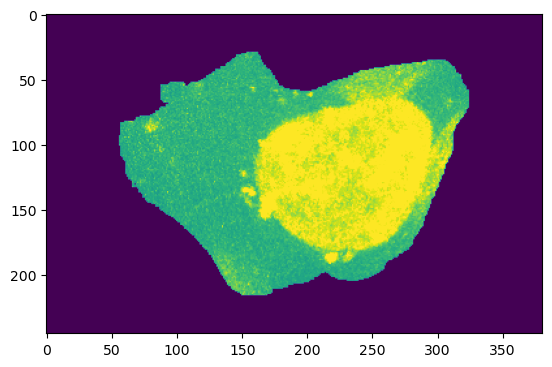

In [42]:
plt.imshow(img[1].max(axis=0))
plt.show()

### Visualize some edge cell

In [43]:
some_cell = cells_edgeVSnoedge[cells_edgeVSnoedge.edge_flag == 1].sample(1).iloc[0]

img = image_loader(
    some_cell.registered_path,
    transform=rescale_image,
    return_as_torch=False
)

img.shape

(7, 136, 245, 381)

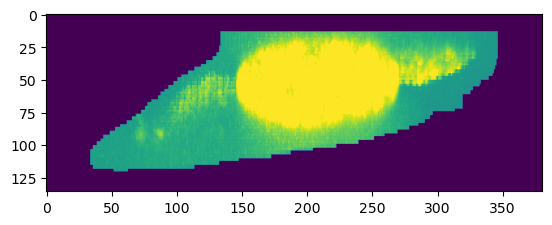

In [44]:
plt.imshow(img[1].max(axis=1))
plt.show()

In [45]:
some_cell[[col for col in some_cell.index if "fits" in col]]

fits_z    True
fits_y    True
fits_x    True
Name: 172643, dtype: object

### Configuring serotiny

As refered to above, `serotiny` requires you to have configured 5 modules. 
**TODO** general blurp about config syntax

#### `data` config

**TODO** Incrementally build up this yaml here in the markdown

```
_target_: serotiny.datamodules.ManifestDatamodule

path: /home/aicsuser/serotiny_data/cells_edgeVSnoedge.csv

batch_size: 64
num_workers: 1
loaders:
  id:
    _target_: serotiny.io.dataframe.loaders.LoadColumn
    column: CellId
    dtype: int
  class:
    _target_: serotiny.io.dataframe.loaders.LoadColumn
    column: edge_flag
    dtype: float32
  image:
    _target_: serotiny.io.dataframe.loaders.LoadImage
    column: max_projection_z
    select_channels: ['membrane']  
    
split_column: "split"
```

#### `model` config

The next module we'll  configure is the `model` module.

**TODO** Incrementally build up this yaml here in the markdown

**TODO/Recommendation** Let's use the long-form yaml config, instead of yaml variables (and keep this version under the Advanced subsection below)


```
_aux_: 
  _a: &hidden_channels 4
  _b: &kernel_size 3
  _c: &conv_block
    _target_: torch.nn.Sequential
    _args_:
      - _target_: torch.nn.LazyConv2d
        out_channels: *hidden_channels
        kernel_size: *kernel_size
        stride: 1
      - _target_: torch.nn.LeakyReLU
      - _target_: torch.nn.LazyBatchNorm2d

_target_: serotiny.models.BasicModel
x_label: image
y_label: class
network:
  _target_: torch.nn.Sequential
  _args_:
    - *conv_block
    - *conv_block
    - *conv_block
    - _target_: serotiny.networks.layers.Flatten
    - _target_: torch.nn.LazyLinear
      out_features: 1
    - _target_: torch.nn.Sigmoid
    
loss:
  _target_: torch.nn.BCELoss
  
# a function used by `serotiny predict` to store the results of feeding data through the model
save_predictions:
  _target_: cytodata_aics.model_utils.save_predictions_classifier
  _partial_: true

# fields to include in the output for each batch
fields_to_log:
  - id
 
```

##### **Advanced version**

This version uses some YAML tricks and the `_aux_` section (which is ignored by `serotiny`) to
more flexibly build models

```
_aux_: 
  _a: &hidden_channels 4
  _b: &kernel_size 3
  _c: &conv_block
    _target_: torch.nn.Sequential
    _args_:
      - _target_: torch.nn.LazyConv2d
        out_channels: *hidden_channels
        kernel_size: *kernel_size
        stride: 1
      - _target_: torch.nn.LeakyReLU
      - _target_: torch.nn.LazyBatchNorm2d

_target_: serotiny.models.BasicModel
x_label: image
y_label: class
network:
  _target_: torch.nn.Sequential
  _args_:
    - *conv_block
    - *conv_block
    - *conv_block
    - _target_: serotiny.networks.layers.Flatten
    - _target_: torch.nn.LazyLinear
      out_features: 1
    - _target_: torch.nn.Sigmoid
    
loss:
  _target_: torch.nn.BCELoss
  
  
# a function used by `serotiny predict` to store the results of feeding data through the model
save_predictions:
  _target_: cytodata_aics.model_utils.save_predictions_classifier
  _partial_: true

# fields to include in the output for each batch
fields_to_log:
  - id
```

#### `trainer` config

####  `trainer/callbacks` config

#### `mlflow` config

#### Changing the working directory

In [46]:
# we need the commands we type to be with respect to the project root
# (because that's what `serotiny` expects) so we change directories here,
# so we can run commands within the notebook
import os
os.chdir("/home/aicsuser/cytodata-hackathon-base")

#### Creating a run name based on the current date and time

In [47]:
from datetime import datetime

# util to avoid referring to the same run unintentionally
now_str = lambda : datetime.now().strftime("%Y%m%d_%H%M%S")

#### Starting a training. Track the training at https://mlflow.a100.int.allencell.org/

In [16]:
run_name = f"Theo_2d_run_{now_str()}"

!serotiny train \
    model=example_classifier_2d \
    data=example_dataloader_2d \
    mlflow=internal_mlflow \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=3

[2022-09-16 21:39:51,961][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmp30mha1pg
[2022-09-16 21:39:51,961][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmp30mha1pg/_remote_module_non_scriptable.py
[2022-09-16 21:39:52,095][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-09-16 21:39:52,095][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-09-16 21:39:52,921][bfio.backends][WARNING] - Java backend is not available. This could be due to a missing dependency (jpype).
[2022-09-16 21:39:53,295][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-09-16 21:39:53,821][pytorch_lightning.utilities.rank

## 5.4 Load a pretrained model

### Make predictions based on the model we just trained

In [17]:
!serotiny predict \
    model=example_classifier_2d \
    data=example_dataloader_2d \
    mlflow=internal_mlflow \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    trainer.gpus=[0]

[2022-09-16 21:43:21,087][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmp2d1y0u6l
[2022-09-16 21:43:21,088][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmp2d1y0u6l/_remote_module_non_scriptable.py
[2022-09-16 21:43:21,222][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-09-16 21:43:21,223][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-09-16 21:43:22,015][bfio.backends][WARNING] - Java backend is not available. This could be due to a missing dependency (jpype).
[2022-09-16 21:43:22,385][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-09-16 21:43:22,945][pytorch_lightning.utilities.rank

### Retrieving predictions from MLFlow

In [48]:
import mlflow
from serotiny.ml_ops.mlflow_utils import download_artifact

In [49]:
mlflow.set_tracking_uri("https://mlflow.a100.int.allencell.org")

with download_artifact("predictions/model_predictions.csv", experiment_name="cytodata_chapter5", run_name="some_2d_run_20220914_161944") as path:
    predictions_2d_df = pd.read_csv(path)

In [57]:
predictions_2d_df = predictions_2d_df.merge(cells_edgeVSnoedge[['CellId','split']].rename(columns={'CellId':'id'}), on = 'id')

In [58]:
predictions_2d_df

,id,y,yhat,loss,split
0,328371,0.0,0.444171,0.513301,train
1,247890,0.0,0.403988,0.511918,train
2,723194,1.0,0.358709,0.555417,train
3,733122,1.0,0.795872,0.555417,train
4,580451,1.0,0.627211,0.555417,train
...,...,...,...,...,...
228,934919,1.0,0.533607,0.750677,train
229,252063,1.0,0.657493,0.750677,valid
230,656977,1.0,0.535824,0.750677,train
231,659493,1.0,0.477967,0.750677,train


## 5.4 Train a classification model based on 3D images

### Configure the 5 yamls and run the training

In [21]:
run_name = f"some_3d_run_{now_str()}"

!serotiny train \
    model=example_classifier_3d \
    data=example_dataloader_3d \
    mlflow=internal_mlflow \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    trainer.gpus=[0] \
    trainer.max_epochs=5 

[2022-09-16 21:45:51,261][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmp0ko3n4cl
[2022-09-16 21:45:51,261][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmp0ko3n4cl/_remote_module_non_scriptable.py
[2022-09-16 21:45:51,395][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-09-16 21:45:51,396][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-09-16 21:45:52,199][bfio.backends][WARNING] - Java backend is not available. This could be due to a missing dependency (jpype).
[2022-09-16 21:45:52,568][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-09-16 21:45:53,109][pytorch_lightning.utilities.rank

Note: The above task takes more the 16GB (it will not fit on the AWS computers) 45618MiB / 81920MiB

### Make predictions from the pretrained model

In [ ]:
!serotiny predict \
    model=example_classifier_3d \
    data=example_dataloader_3d \
    mlflow=internal_mlflow \
    mlflow.experiment_name=cytodata_chapter5 \
    mlflow.run_name={run_name} \
    trainer.gpus=[0]

[2022-09-14 22:18:00,932][torch.distributed.nn.jit.instantiator][INFO] - Created a temporary directory at /tmp/tmpgqf7twou
[2022-09-14 22:18:00,933][torch.distributed.nn.jit.instantiator][INFO] - Writing /tmp/tmpgqf7twou/_remote_module_non_scriptable.py
[2022-09-14 22:18:01,067][pytorch_lightning.utilities.seed][INFO] - Global seed set to 42
[2022-09-14 22:18:01,067][serotiny.ml_ops.ml_ops][INFO] - Instantiating datamodule
[2022-09-14 22:18:01,878][bfio.backends][WARNING] - Java backend is not available. This could be due to a missing dependency (jpype).
[2022-09-14 22:18:02,253][serotiny.ml_ops.ml_ops][INFO] - Instantiating trainer
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
[2022-09-14 22:18:02,881][pytorch_lightning.utilities.rank

### Retrieving predictions from MLFlow

In [22]:
mlflow.set_tracking_uri("https://mlflow.a100.int.allencell.org")

with download_artifact("predictions/model_predictions.csv", experiment_name="cytodata_chapter5", run_name="some_3d_run_20220914_184005") as path:
    predictions_3d_df = pd.read_csv(path)

In [23]:
predictions_3d_df

,id,y,yhat,loss
0,505432,0.0,0.543898,0.507411
1,731269,0.0,0.712607,0.507411
2,293562,0.0,0.508549,0.507411
3,650039,0.0,0.330774,0.507411
4,815494,0.0,0.646111,0.507411
...,...,...,...,...
1995,385347,1.0,0.441637,0.750677
1996,566178,1.0,0.490400,0.750677
1997,715105,1.0,0.571521,0.750677
1998,565668,1.0,0.212761,0.750677
